Epoch 1/30
16/16 [==============================] - 13s 608ms/step - loss: 0.0497
Epoch 2/30
16/16 [==============================] - 10s 603ms/step - loss: 0.0087
Epoch 3/30
16/16 [==============================] - 9s 557ms/step - loss: 0.0051
Epoch 4/30
16/16 [==============================] - 10s 609ms/step - loss: 0.0035
Epoch 5/30
16/16 [==============================] - 10s 617ms/step - loss: 0.0024
Epoch 6/30
16/16 [==============================] - 10s 603ms/step - loss: 0.0018
Epoch 7/30
16/16 [==============================] - 10s 604ms/step - loss: 0.0014
Epoch 8/30
16/16 [==============================] - 9s 558ms/step - loss: 0.0010
Epoch 9/30
16/16 [==============================] - 10s 606ms/step - loss: 8.3403e-04
Epoch 10/30
16/16 [==============================] - 10s 610ms/step - loss: 6.8957e-04
Epoch 11/30
16/16 [==============================] - 10s 602ms/step - loss: 5.8437e-04
Epoch 12/30
16/16 [==============================] - 10s 610ms/step - loss: 5.0362e-04

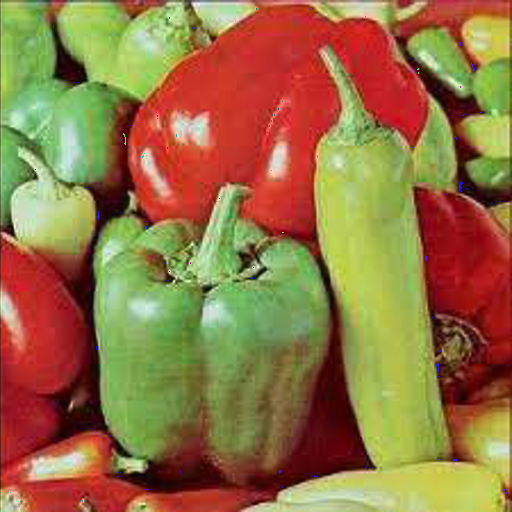

compression rate: 6.2257080078125
GRU PSNR: 42.51504297286164
GRU SSI: 0.9965338329483799
GRU MSE: 3.6439806620279946


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from PIL import Image, ImageDraw
import math

# Load the image and resize it to match the expected sequence length
img = Image.open("peppers_color.tif").resize((512, 512))

# Get the size of the original image
orig_size = img.size

# Convert the image to a numpy array and normalize its values to be between 0 and 1
img_array = np.array(img)
img_array = img_array.astype("float32") / 255.

# Reshape the input data to match the expected input shape of the model
input_dim = 3
input_data = np.reshape(img_array, (512, 512, input_dim))

# Define the RNN model with GRU layers
hidden_dim = 100
output_dim = 3

model = Sequential()
model.add(GRU(hidden_dim, input_shape=(None, input_dim), return_sequences=True))
for i in range(2):
    model.add(GRU(hidden_dim, return_sequences=True))
model.add(Dense(output_dim))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(input_data, input_data, epochs=30)

# Generate the compressed image using the trained GRU model
compressed_img_array = model.predict(input_data)

# Convert the compressed image array back to an image
compressed_img = Image.fromarray((compressed_img_array * 255).astype("uint8"))

compressed_img.show()

# Calculate compression rate
num_bits = model.count_params() * 32  # total number of bits used to represent the model
num_pixels = orig_size[0] * orig_size[1] * 3  # total number of pixels in the original image
compression_rate_gru = num_bits / num_pixels
print("compression rate:", compression_rate_gru)


# Calculate PSNR, SSI, and MSE
orig_img_array = np.array(img)
compressed_img_array = np.array(compressed_img)

max_pixel_val = 255

mse_gru = np.mean((orig_img_array - compressed_img_array) ** 2)
psnr_gru = 20 * math.log10(max_pixel_val / math.sqrt(mse_gru))
ssi_gru = np.sum((orig_img_array - np.mean(orig_img_array)) * (compressed_img_array - np.mean(compressed_img_array))) / np.sqrt(np.sum((orig_img_array - np.mean(orig_img_array)) ** 2) * np.sum((compressed_img_array - np.mean(compressed_img_array)) ** 2))

print("GRU PSNR:", psnr_gru)
print("GRU SSI:", ssi_gru)
print("GRU MSE:", mse_gru)


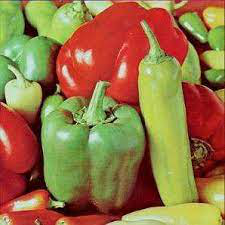

compression rate: 8.0
psnr: 44.93516979797402
ssi: 0.9997526699730358
mse: 2.08719670781893


In [ ]:
from PIL import Image
import numpy as np
import math

# Load the image
img = Image.open("peppers_color.tif")

# Convert the image to a numpy array
img_array = np.array(img)

# Compress the image using JPEG compression
compressed_img = Image.fromarray(img_array)
compressed_img.save("lena_compressed.jpg", format="JPEG", quality=90)
compressed_img.show()
# Load the compressed image and convert it to a numpy array
compressed_img = Image.open("lena_compressed.jpg")
compressed_img_array = np.array(compressed_img)

# Calculate the size of the original and compressed images
orig_size = img.size
compressed_size = compressed_img.size

# Calculate compression rate
num_bits = compressed_size[0] * compressed_size[1] * 3 * 8  # total number of bits used to represent the compressed image
num_pixels = orig_size[0] * orig_size[1] * 3  # total number of pixels in the original image
compression_rate_jpeg = num_bits / num_pixels
print("compression rate:", compression_rate_jpeg)

# Calculate PSNR, SSI, and MSE
max_pixel_val = 255

mse_jpeg = np.mean((img_array - compressed_img_array) ** 2)
psnr_jpeg = 20 * math.log10(max_pixel_val / math.sqrt(mse_jpeg))
ssi_jpeg = np.sum((img_array - np.mean(img_array)) * (compressed_img_array - np.mean(compressed_img_array))) / np.sqrt(np.sum((img_array - np.mean(img_array)) ** 2) * np.sum((compressed_img_array - np.mean(compressed_img_array)) ** 2))

print("psnr:", psnr_jpeg)
print("ssi:", ssi_jpeg)
print("mse:", mse_jpeg)

In [ ]:
import pandas as pd

# Create a dataframe to display the metrics
data = {
    "Compression Method": ["GRU", "JPEG"],
    "Compression Rate": [compression_rate_gru, compression_rate_jpeg],
    "PSNR": [psnr_gru, psnr_jpeg],
    "SSI": [ssi_gru, ssi_jpeg],
    "MSE": [mse_gru, mse_jpeg]
}

df = pd.DataFrame(data)

# Display the dataframe
display(df)


,Compression Method,Compression Rate,PSNR,SSI,MSE
0,GRU,6.225708,42.515043,0.996534,3.643981
1,JPEG,8.000000,44.935170,0.999753,2.087197


In [ ]:
from prettytable import PrettyTable

# Create a prettytable object
table = PrettyTable()

# Add columns to the table
table.field_names = ["Compression Method", "Compression Rate", "PSNR", "SSI", "MSE"]

# Add rows to the table
table.add_row(["GRU", compression_rate_gru, psnr_gru, ssi_gru, mse_gru])
table.add_row(["JPEG", compression_rate_jpeg, psnr_jpeg, ssi_jpeg, mse_jpeg])

# Display the table
print(table)


+--------------------+------------------+-------------------+--------------------+--------------------+
| Compression Method | Compression Rate |        PSNR       |        SSI         |        MSE         |
+--------------------+------------------+-------------------+--------------------+--------------------+
|        GRU         | 6.2257080078125  | 42.51504297286164 | 0.9965338329483799 | 3.6439806620279946 |
|        JPEG        |       8.0        | 44.93516979797402 | 0.9997526699730358 |  2.08719670781893  |
+--------------------+------------------+-------------------+--------------------+--------------------+
